## 09. 분류 실습 - 캐글 산탄데르 고객 만족 예측
### XGBoost 모델 학습과 하이퍼 파라미터 튜닝


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_tr, y_tr),
                                                                                (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

In [ ]:
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsmple_bytree는 0.5에서 0.95 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          colsample_bytree=search_space['colsample_bytree'],
                          learning_rate=search_space['learning_rate'])

  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf.split(X_trian)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
                eval_set=[(X_tr, y_tr), (X_val, y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[22]	validation_0-auc:0.90439	validation_1-auc:0.82729
[23]	validation_0-auc:0.90507	validation_1-auc:0.82820
[24]	validation_0-auc:0.90590	validation_1-auc:0.82771
[25]	validation_0-auc:0.90669	validation_1-auc:0.82847
[26]	validation_0-auc:0.90836	validation_1-auc:0.82965
[27]	validation_0-auc:0.90970	validation_1-auc:0.82947
[28]	validation_0-auc:0.91131	validation_1-auc:0.83014
[29]	validation_0-auc:0.91183	validation_1-auc:0.83063
[30]	validation_0-auc:0.91203	validation_1-auc:0.83035
[31]	validation_0-auc:0.91254	validation_1-auc:0.83014
[32]	validation_0-auc:0.91333	validation_1-auc:0.82944
[33]	validation_0-auc:0.91352	validation_1-auc:0.82935
[34]	validation_0-auc:0.91388	validation_1-auc:0.82896
[35]	validation_0-auc:0.91421	validation_1-auc:0.82882
[36]	validation_0-auc:0.91417	validation_1-auc:0.82852
[37]	validation_0-auc:0.91460	validation_1-auc:0.82793
[38]	validation_0-auc:0.91527	validation_1-auc:0.82808
[39]	validation_0-auc:0.91558

In [ ]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'],5),
                        max_depth=int(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81511	validation_1-auc:0.79149
[1]	validation_0-auc:0.81226	validation_1-auc:0.78779
[2]	validation_0-auc:0.82251	validation_1-auc:0.79360
[3]	validation_0-auc:0.82320	validation_1-auc:0.79587
[4]	validation_0-auc:0.83290	validation_1-auc:0.80839
[5]	validation_0-auc:0.83142	validation_1-auc:0.80352
[6]	validation_0-auc:0.82841	validation_1-auc:0.80015
[7]	validation_0-auc:0.83219	validation_1-auc:0.80506
[8]	validation_0-auc:0.83660	validation_1-auc:0.81126
[9]	validation_0-auc:0.83465	validation_1-auc:0.80769
[10]	validation_0-auc:0.83211	validation_1-auc:0.80516
[11]	validation_0-auc:0.83581	validation_1-auc:0.80956
[12]	validation_0-auc:0.83887	validation_1-auc:0.81518
[13]	validation_0-auc:0.83681	validation_1-auc:0.81135
[14]	validation_0-auc:0.83929	validation_1-auc:0.81498
[15]	validation_0-auc:0.83795	validation_1-auc:0.81138
[16]	validation_0-auc:0.83693	validation_1-auc:0.80965
[17]	validation_0-auc:0.83590	validation_1-auc:0.80874
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

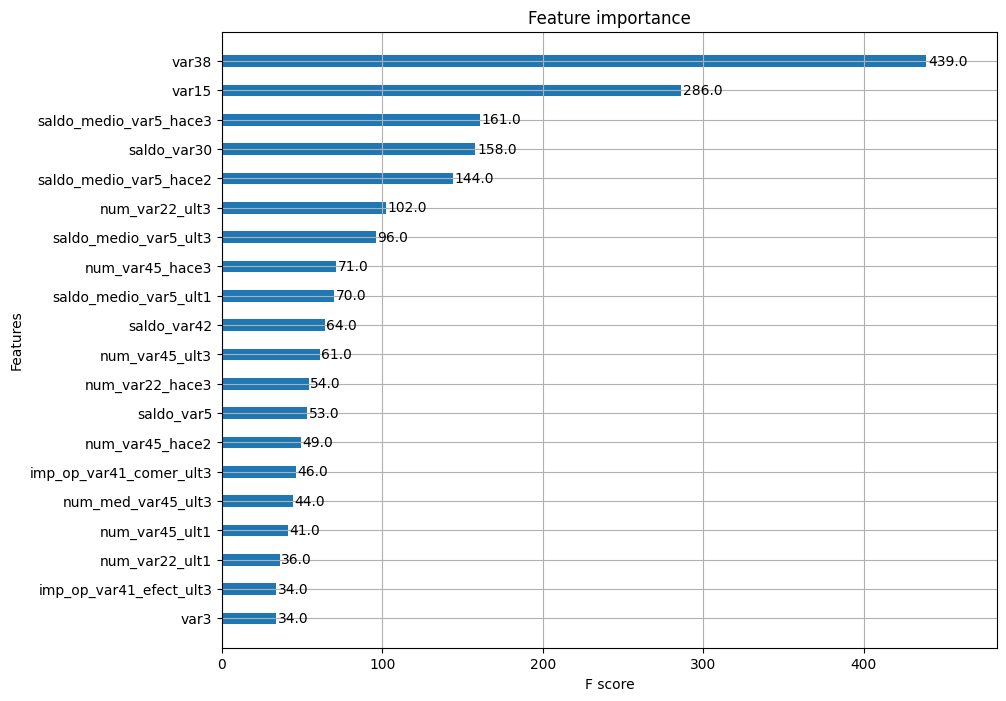

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [ ]:
from lightgbm import LGBMClassifier, early_stopping

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)], eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13224
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[32]	training's auc: 0.901984	training's binary_logloss: 0.11585	valid_1's auc: 0.829103	valid_1's binary_logloss: 0.136182
ROC AUC: 0.8326


In [ ]:
lgbm_search_space = {'num_leaves':hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth':hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples':hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample':hp.uniform('subsample', 0.7, 1),
                     'learning_rate':hp.uniform('learning_rate', 0.01, 0.2)}

In [ ]:
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(n_estimators=100,
                            num_leaves=int(search_space['num_leaves']),
                            max_depth=int(search_space['max_depth']),
                            min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['learning_rate'],
                            learning_rate=search_space['learning_rate'])

  # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
  roc_auc_list=[]

  # 3개 k-fold 방식 적용
  kf = KFold(n_splits=3)
  # X_train을 다시 학습과 검증용 데이터로 분리
  for tr_index, val_index in kf.split(X_train):
    # kf,split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
    X_tr, y_tr=X_train.iloc[tr_index], y_train.iloc[tr_index]
    X_val, y_val=X_train.iloc[val_index], y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행.
    lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=30)], eval_metric="auc",
                 eval_set=[(X_tr, y_tr), (X_val,y_val)])

    # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결괏값 담음.
    score=roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
    roc_auc_list.append(score)

  # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
  # HyperOpt는 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
  return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
          max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.88765	training's binary_logloss: 0.121808	valid_1's auc: 0.831519	valid_1's binary_logloss: 0.135868
[LightGBM] [Info] Number of positive: 1609, number of negative: 38935
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065205 seconds.
You can set `force_row_wise=true` 

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=500, num_leaves=int(best['num_leaves']),
                          max_depth=int(best['max_depth']),
                          min_child_samples=int(best['min_child_samples']),
                          subsample=round(best['subsample'],5),
                          learning_rate=round(best['learning_rate'],5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=100)],
             eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12895
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's auc: 0.89977	training's binary_logloss: 0.11716	valid_1's auc: 0.832981	valid_1's binary_logloss: 0.135466
ROC AUC: 0.8419


## 10. 분류 실습 - 캐글 신용카드 사기 검출
### 언더 샘플링과 오버 샘플링의 이해
- 언더 샘플링: 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식
- 오버 샘플링: 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법

# CH 05. 회귀
## 01. 회귀 소개
- 회귀: 여러 개의 독립변수와 한 개의 종속변수 간의 상관관계를 모델링하는 기법
- 지도학습은 분류와 회귀로 나뉨. 분류는 예측값이 이산형 클래스이고 회귀는 연속형 숫자 값임.
## 02. 단순 선형 회귀를 통한 회귀 이해
- 단순 선형 회귀: 독립변수도 하나, 종속변수도 하나인 선형 회귀
## 03. 비용 최소화하기 - 경사 하강법(Gradient Descent) 소개
- 경사 하강법: 점진적으로 반복적인 계산을 통해 W 파라미터 값을 업데이트하면서 오류 값이 최소가 되는 W 파라미터를 구하는 방식
### 회귀 평가 지표
- MAE, MSE, RMSE, R^2
### 다항 회귀를 이용한 과소적합 및 과적합 이해
- 다항회귀는 복잡한 다항 관계를 모델링 할 수 있음. 다항식의 차수가 높아질수록 복잡한 피처 간의 관계까지 모델링이 가능함. 하지만 차수를 높일수록 과적합의 문제가 발생함.
### 편향 - 분산 트레이드오프(Bias-Variance Trade off)
- 편향과 분산은 한쪽이 높으면 한쪽이 낮아지는 경향이 있음. 편항과 분산이 서로 트레이드오프를 이루면서 오류 Cast 값이 최대로 낮아지는 모델을 구축하는 것이 가장 효율적인 머신러닝 예측 모델을 만드는 방법임.
## 06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
### 규제선형 모델의 개요
- 비용 함수 목표: RSS(W)+alpha*||W||^2_2
- 규제: 비용함수에 알파 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
- L1 규제 / L2 규제
- L2 규제: W의 제곱에 대해 페널티를 부여하는 방식 -> 릿지 회귀
- L1 규제: W의 절댓값에 대해 페널티를 부여하는 방식 -> 라쏘 회귀
## 07. 로지스틱 회귀
- 로지스틱 회귀: 선형 회귀 방식을 분류에 적용한 알고리즘
## 08. 회귀 트리
- 회귀를 위한 트리를 생성하고 이를 기바느올 회귀 예측 수행

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the boston dataset from the original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(data, columns=feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICe 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = target

X_data = pd.DataFrame(data)
y_target = pd.Series(target, name='PRICE')

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores： ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 교차 검증의 개별 Negative MSE scores：  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
  neg_mse_scores=cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
  rmse_scores=np.sqrt(-1*neg_mse_scores)
  avg_rmse=np.mean(rmse_scores)
  print('#####',model.__class__.__name__,'#####')
  print('5 교차 검증의 평균 RMSE:{0:.3f}'.format(avg_rmse))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
  get_model_cv_prediction(model, X_data, y_target)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

<Axes: xlabel='None', ylabel='None'>

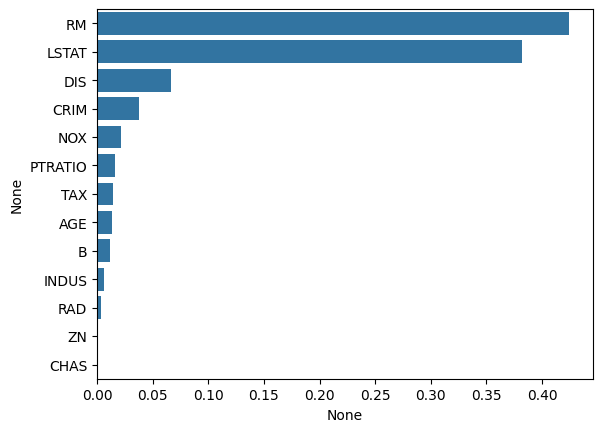

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X.data, y_target 데이터 세트를 적용해 학습한다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


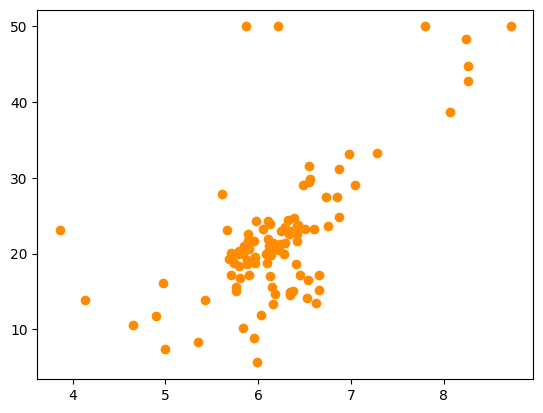

In [ ]:
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt .figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

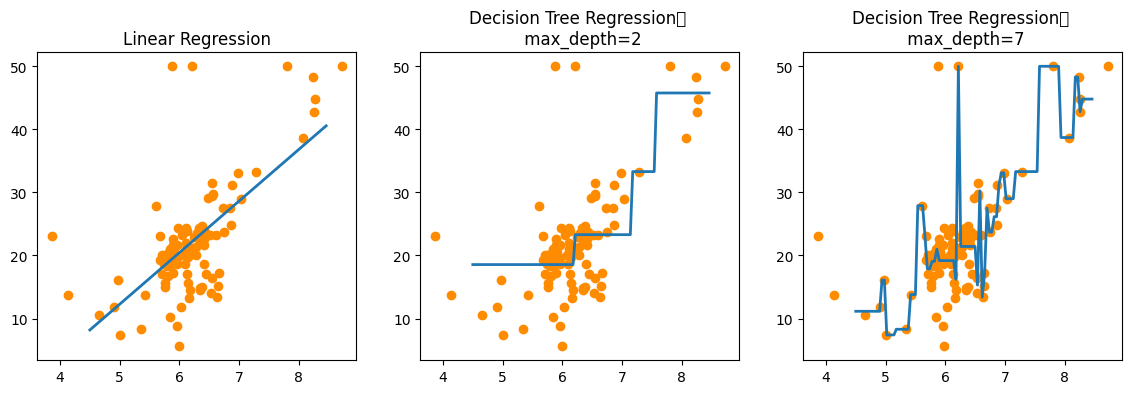

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

# X 축 값을 4.5 ~ 8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression： \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth：3", linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression： \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

## 09. 회귀 실습 - 자전거 대여 수요 예측
## 10. 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법
# CH06. 차원 축소
## 01. 차원 축소(Dimension Reduction) 개요
- PCA, LDA, SVD, NMF
- 매우 많은 피처로 구성된 다차원 데이터 세트의 차원을 축소해 새로운 차원의 데이터 세트를 생성
- 피처 선택 / 피처 추출
## 02. PCA(Principal Component Analysis)
### PCA 개요
- 가장 대표적인 차원 축소 기법으로, PCA는 여러 변수 간에 존재하는 상관관계를 이용해 이를 대표하는 주성분을 추출해 차원을 축소하는 기법임. 입력 데이터의 변동성이 가장 큰 축을 찾음.
## 03. LDA(Linear DIscriminant Analysis)
### LDA 개요
- 선형 판별 분석법으로 불리며, PCA와 유사. 입력 데이터 세트를 저차원 공간에 투영해 차원을 축소하는 기법, 지도학습의 분류에서 사용하기 쉽도록 개별 클래스를 분별할 수 있는 기준을 최대한 유지하면서 차원을 축소함. 입력 데이터의 결정 값 클래스를 최대한으로 분리할 수 있는 축을 찾음.
## 04. SVA(Singular Value Decomposition)
### SVD 개요
- 행렬 분해 기법 이용. 행과 열이 다른 행렬에도 적용 가능.특이값 분해로 불림.
## 05. NMF(Non-Negative Matrix Factorization)
### NMF 개요
- 낮은 랭크를 통한 행렬 근사 방식의 변형임.행렬 내의 모든 원소 값이 모두 양수라는 게 보장되면 간단하게 주개이 기반 양수 행렬로 분해될 수 있는 기법을 지칭함.
# CH07. 군집화
## 01. K-평균 알고리즘 이해
- K-평균은 군집 중심점이라는 특정한 임의의 지점을 선택해 해당 중심에 가장 가까운 포인트들을 선택하는 군집화 기법이다.
### 사이킷런 KMeans 클래스 소개

In [ ]:
# class sklearn.cluster.KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001,
#                              precompute_distances='auto', verbose=0, random_state=None,
#                              copy_x=True, n_jobs=1, algorithm='auto')

### K-평균을 이용한 붓꽃 데이터 세트 군집화

In [ ]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
# 더 편리한 데이터 핸들링을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(irisDF)

KMeans(n_clusters=3, random_state=0)

In [ ]:
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [ ]:
irisDF['target'] = iris.target
irisDF['cluster'] = kmeans.labels_
iris_result = irisDF.groupby(['target', 'cluster'])['sepal_length'].count()
print(iris_result)

target  cluster
0       1          50
1       0          47
        2           3
2       0          14
        2          36
Name: sepal_length, dtype: int64


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(iris.data)

irisDF['pca_x'] = pca_transformed[:,0]
irisDF['pca_y'] = pca_transformed[:,1]
irisDF.head(3)

,sepal_length,sepal_width,petal_length,petal_width,target,cluster,pca_x,pca_y
0,5.1,3.5,1.4,0.2,0,1,-2.684126,0.319397
1,4.9,3.0,1.4,0.2,0,1,-2.714142,-0.177001
2,4.7,3.2,1.3,0.2,0,1,-2.888991,-0.144949


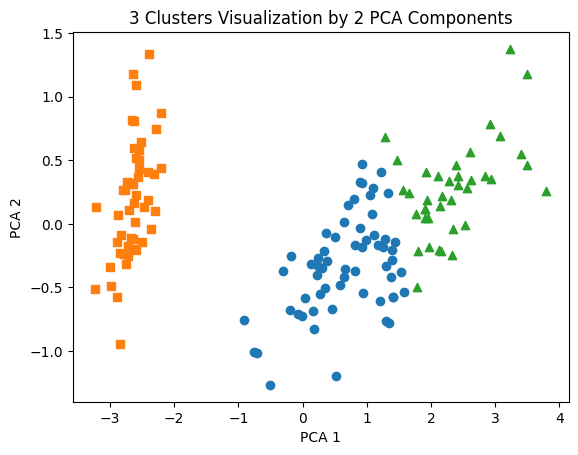

In [ ]:
# 군집 값이 0,1,2인 경우마다 별도의 인덱스로 추출
marker0_ind = irisDF[irisDF['cluster']==0].index
marker1_ind = irisDF[irisDF['cluster']==1].index
marker2_ind = irisDF[irisDF['cluster']==2].index

# 군집 값 0,1,2에 해당하는 인덱스로 각 군집 레벨의 pca_x, pca_y 값 추출. o,s,^로 마커 표시
plt.scatter(x=irisDF.loc[marker0_ind, 'pca_x'], y=irisDF.loc[marker0_ind, 'pca_y'], marker='o')
plt.scatter(x=irisDF.loc[marker1_ind, 'pca_x'], y=irisDF.loc[marker1_ind, 'pca_y'], marker='s')
plt.scatter(x=irisDF.loc[marker2_ind, 'pca_x'], y=irisDF.loc[marker2_ind, 'pca_y'], marker='^')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('3 Clusters Visualization by 2 PCA Components')
plt.show()

## 02. 군집 평가(Cluster Evaluation)
### 실루엣 분석의 개요
- 실루엣 분석은 각 군집 간의 거리가 얼마나 효율적으로 분리돼 있는지를 나타냄.
### 붓꽃 데이터 세트를 이용한 군집 평가

In [ ]:
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
# 실루엣 분석 평가 지표 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal.width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(irisDF)
irisDF['cluster'] = kmeans.labels_

# iris의 모든 개별 데이터에 실루엣 계수 값을 구함.
score_samples = silhouette_samples(iris.data, irisDF['cluster'])
print('silhouette_samples() return 값의 shape', score_samples.shape)

# irisDF에 실루엣 계수 칼럼 추가
irisDF['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수 값을 구함.
average_score = silhouette_score(iris.data, irisDF['cluster'])
print('붓꽃 데이터 세트 Silhouette Analysis Score:{0:.3f}'.format(average_score))
irisDF.head(3)

silhouette_samples() return 값의 shape (150,)
붓꽃 데이터 세트 Silhouette Analysis Score:0.551


,sepal_length,sepal_width,petal_length,petal.width,cluster,silhouette_coeff
0,5.1,3.5,1.4,0.2,1,0.852582
1,4.9,3.0,1.4,0.2,1,0.814916
2,4.7,3.2,1.3,0.2,1,0.828797


In [ ]:
irisDF.groupby('cluster')['silhouette_coeff'].mean()

,silhouette_coeff
cluster,
0,0.422323
1,0.797604
2,0.436842


## 03. 평균 이동
### 평균 이동의 개요
- 중심을 군집의 중심으로 지속적으로 움직이면서 군집화를 수행함. 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킴.
## 04. GMM(Gaussian Mixture Model)
### GMM 소개
- GMM 군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식임.
## 05. DBSCAN
### DBSCAN 개요
- 밀도 기반 군집화의 대표적인 알고리즘. 특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 하고 있어 복잡한 기하학적 분포도를 가진 데이터 세트에 대해서도 군집화를 잘 수행함.